# TP 2: segmentation and classification of PreTest signals
Topics:
-  Noisy labels
-  Imbalanced dataset
-  Feature extraction
-  Dimension reduction

In [210]:
%load_ext autoreload
%autoreload 2
from data_exploration import get_data, prepare_data, prepare_augmented_dataset, get_dataset_balance
import matplotlib.pyplot as plt
import numpy as np
from data_analyzis import get_pressure_pca, plot_pressure_pca, plot_gmm_fit_pca

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
data = get_data()
pressure, labels = prepare_data(data)

['station_reference', 'drawdown_start_idx', 'drawdown_end_idx', 'buildup_start_idx', 'buildup_end_idx', 'drawdown_volume', 'drawdown_pressure', 'buildup_volume', 'buildup_pressure', 'buildup_label']


In [ ]:
plt.figure(figsize=(10,10))
for press, label in zip(pressure, labels):
    plt.plot(press, "g-" if label==1 else "r-", alpha=0.1)
plt.xlabel("Normalized temporal index")
plt.ylabel("Normalized pressure measurements")
plt.title("Labelled Normalized pressure measurements for all runs\nGreen: Normal, Red: Faulty")
plt.grid()
plt.show()

# Preliminary data analyzis

In [ ]:
plt.figure(figsize=(10,10))
for press, label in zip(pressure, labels):
    plt.plot(press - np.linspace(0, 1, len(press)), "g-" if label==1 else "r-", alpha=0.1)
plt.xlabel("Normalized temporal index")
plt.ylabel("Normalized pressure measurements")
plt.title("Pressure measurements after major trend removal\nGreen: Normal, Red: Faulty")
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
pos, neg = [], []
for press, label in zip(pressure, labels):
    max_feature = np.max(press - np.linspace(0, 1, len(press)))
    if label == 1:
        pos.append(max_feature)
    else:
        neg.append(max_feature)
plt.hist(pos, bins=30, alpha=0.5, label="Normal", color="green")
plt.hist(neg, bins=30, alpha=0.5, label="Faulty", color="red")
plt.title("Histogram of an handcrafted feature: Max on pressure profile after trend removal\nGreen: Normal, Red: Faulty")
plt.grid()
plt.show()

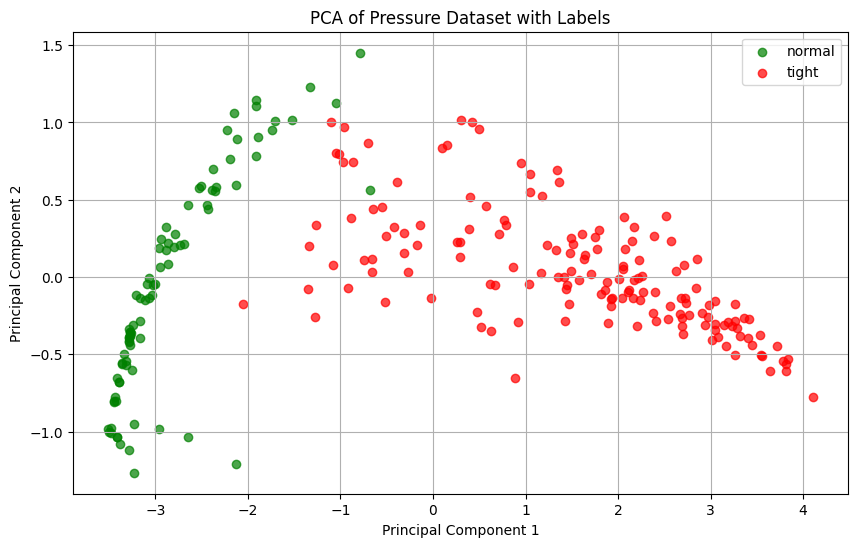

In [196]:
pressure_pca, pca = get_pressure_pca(pressure)
plot_pressure_pca(pressure_pca, labels)

In [ ]:
plot_gmm_fit_pca(pressure, pressure_pca, labels, pca)

# Imbalanced + noisy labels dataset

In [208]:
get_dataset_balance(labels, desc="Original dataset")

Original dataset Total normal samples: 85 = 35.1%
Original dataset Total tight samples: 157 = 64.9%


Forced imbalance 40% tight Total normal samples: 94 = 60.3%
Forced imbalance 40% tight Total tight samples: 62 = 39.7%


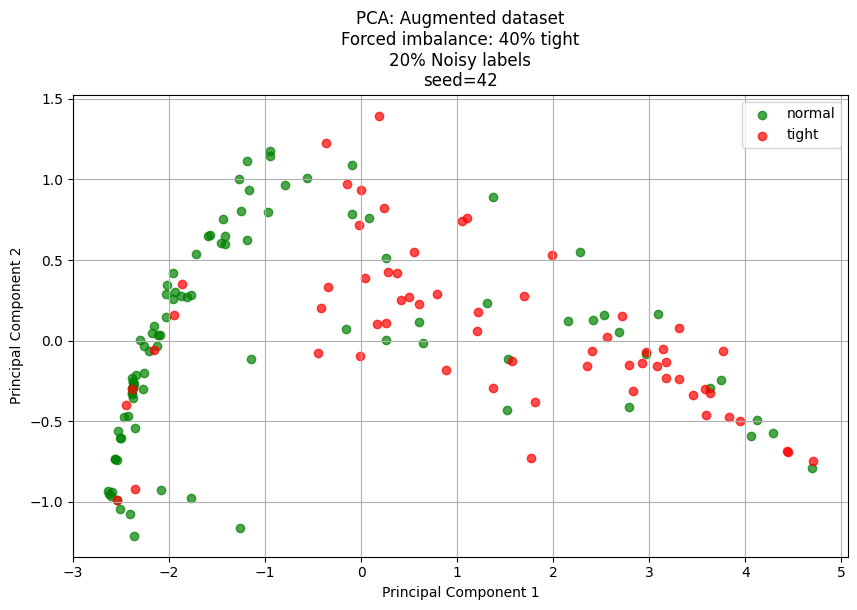

Forced imbalance 40% tight Total normal samples: 101 = 60.1%
Forced imbalance 40% tight Total tight samples: 67 = 39.9%


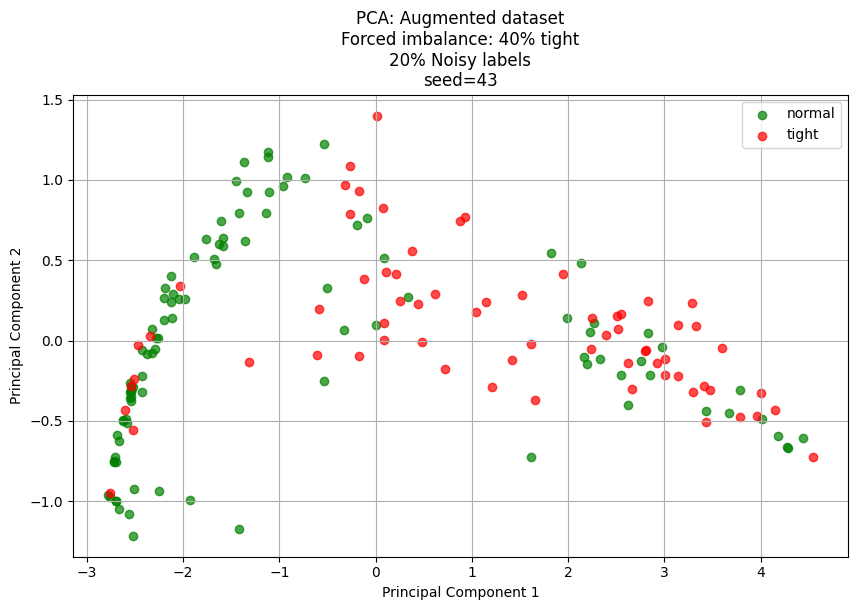

In [227]:
ratio_tight = 0.4
noisy_label_ratio = 0.2
for seed in [42, 43]:
    pressure_imb, labels_imb = prepare_augmented_dataset(
        pressure, labels,
        ratio_tight=ratio_tight,
        ratio_noisy_label=noisy_label_ratio,
        seed=seed
    )
    get_dataset_balance(labels_imb, desc=f"Forced imbalance {ratio_tight:.0%} tight")
    pressure_pca, pca = get_pressure_pca(pressure_imb)
    plot_pressure_pca(pressure_pca, labels_imb, desc=f"Augmented dataset\nForced imbalance: {ratio_tight:.0%} tight\n{noisy_label_ratio:.0%} Noisy labels\nseed={seed}")

In [236]:
pressure_imb, labels_imb
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(pressure_imb, labels_imb)

In [237]:
train_data.shape, test_data.shape

((126, 200), (42, 200))

In [245]:
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# First, predict the labels for the test set

classifier = RidgeClassifier()
classifier = DecisionTreeClassifier()
classifier.fit(train_data, train_label)



Precision: 74.19%
Recall: 95.83%
Confusion Matrix:
[[10  8]
 [ 1 23]]


In [257]:
def evaluate(classifier, test_data, test_label):
    predicted_labels = classifier.predict(test_data)

    # Calculate Precision
    precision = precision_score(test_label, predicted_labels, average='binary') # Change average as per your need

    # Calculate Recall
    recall = recall_score(test_label, predicted_labels, average='binary') # Change average as per your need

    # Generate the Confusion Matrix
    conf_matrix = confusion_matrix(test_label, predicted_labels, 
                                   #normalize='all',
    )

    # Print the results
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"Confusion Matrix:\n{conf_matrix}")

In [258]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
pca = PCA(n_components=2)
rigde_classifier = RidgeClassifier()
decision_tree = DecisionTreeClassifier()

# pipeline = Pipeline(steps=[('pca', pca), ('decision_tree', decision_tree)])
pipeline = Pipeline(steps=[('pca', pca), ('rigde_classifier', rigde_classifier)])
pipeline = Pipeline(steps=[('pca', pca), ('svm', SVC())])
pipeline.fit(train_data, train_label)
evaluate(pipeline, test_data, test_label)

Precision: 89.47%
Recall: 70.83%
Confusion Matrix:
[[16  2]
 [ 7 17]]


# Classification

- Precision: classified a normal event as normal $\frac{tp}{tp+fp}$: *classifier ability not to label as positive a sample that is negative.* 💲
- Recall: classified  $\frac{tp}{tp+fn}$ : *the classifier ability to find all the positive samples.*. We want a recall of 100% here ❌ !
- Confusion matrix: $C_{i, j}$
  - $i$ groundtruth class
  - $j$ predicted class

| Confusion matrix | Prediction $j=0$ Tight| Prediction $j=1$ Normal |
| :---: | ------ | ------ |
|**Groundtruth $i=0$ Tight**| True Negative (groundtruth=tight, prediction=tight) ✔️ | False Positive (groundtruth=tight,prediction=normal) 💲 |
|**Groundtruth $i=1$ Normal**| False Negative (groundtruth=normal, prediction=Tight) ❌ | True Positive (groundtruth=normal, prediction=normal) ✔️ |
